In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sts
from scipy.stats import sem


In [3]:
import datetime as dt
import random

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
inspector = inspect(engine)

# reflect the tables
inspector.get_table_names() 

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base = automap_base() 
Base.prepare(engine, reflect=True)
Base.classes.keys() 

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station 

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall() 

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [13]:
engine.execute('SELECT * FROM station').fetchall() 

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastdate = session.query(Measurement.station, Measurement.prcp, Measurement.date).\
           order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation=session.query( Measurement.date, Measurement.prcp).\
              filter(Measurement.date >= query_date).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precipitation[:], columns=[ 'date', 'prcp'])
df.set_index('date', inplace=True, )

# Sort the dataframe by date
df_date=df.sort_values(by='date')
df_date

prcp
date            
2016-08-23  0.70
2016-08-23  0.00
2016-08-23  0.15
2016-08-23  1.79
2016-08-23   NaN
...          ...
2017-08-22  0.00
2017-08-23  0.45
2017-08-23  0.08
2017-08-23  0.00
2017-08-23  0.00

[2230 rows x 1 columns]

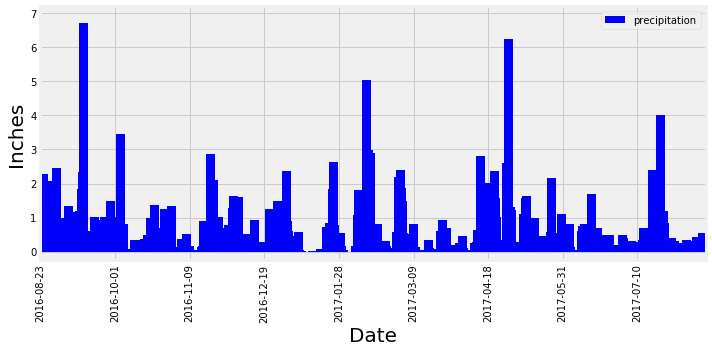

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
x_axis = np.arange(len(df_date))
tick=np.arange(1,len(df),250)
plt.bar(x_axis, df_date["prcp"] ,color='b' , label='precipitation',width=30)
plt.xticks(tick, df_date.index[tick],rotation="vertical")
plt.xlim(-0.25, len(x_axis)-0.25)
plt.ylim(-0.25, df_date["prcp"].max()+0.5)
plt.xlabel("Date",fontsize=20)
plt.ylabel("Inches",fontsize=20)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation=df['prcp']
count=df.count()
mean=df.mean()
std=df.std()
min=df.min()
max=df.max()
quartiles = precipitation.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
median = quartiles[0.5]
df_summary= pd.DataFrame({"count":count, "mean": mean,'std':std, "min":min,\
                    "25%":lowerq,"50%":median,"75%":upperq,"max":max
                   })
summary = df_summary.T
summary

prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
stations

9

In [19]:
stations = session.query(Measurement.station).distinct().all()
stations
a = list(np.ravel(stations))
a

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

#re = list(np.ravel(station_list))
station=[result[0] for result in station_list][0]
#station=station_list[0][0]
print(f"The most active station is {station}")
station_list


The most active station is USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_record = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station == station).all()
    
records = list(np.ravel(station_record)) #unpack turple

print(f'The lowest temperature recorded is {records[1]}')
print(f'The highest temperature recorded is {records[2]}')
print(f'The average temperature recorded is {records[3]}')


The lowest temperature recorded is 54.0
The highest temperature recorded is 85.0
The average temperature recorded is 71.66378066378067


In [22]:
station_record

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

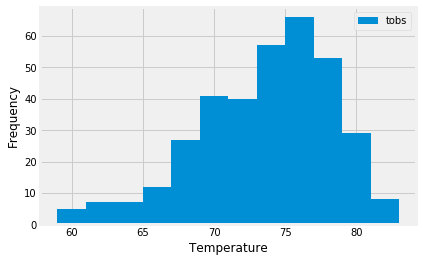

<Figure size 432x288 with 0 Axes>

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#highest_station=session.query(Measurement.station, func.max(Measurement.tobs)).scalar()
#highest_station
stmt = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == station).statement
station_df = pd.read_sql_query(stmt, session.bind)
#station_df.set_index('station', inplace=True, )
station_df

temperatures=station_df['tobs']
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc="upper right")
plt.show()
plt.tight_layout()
#print(sts.normaltest(temperatures.sample(50)))

In [24]:
dates = session.query(Measurement.date).all()
dates[-1]

('2017-08-23')

## Bonus Challenge Assignment

In [25]:
tobs_df = pd.read_csv('Resources/hawaii_measurements.csv')
#['tobs'].dropna()


In [26]:

tobs_df['month']=pd.DatetimeIndex(tobs_df['date']).month

june_df=tobs_df.loc[tobs_df['month']==6]
june_df.set_index('month',inplace=True)
average_june=june_df['tobs'].mean()
tobs6=june_df['tobs']

december_df=tobs_df.loc[tobs_df['month']==12]
december_df.set_index('month',inplace=True)
december_df
average_december=december_df['tobs'].mean()
tobs12=december_df['tobs']

sts.ttest_ind(tobs6, tobs12, equal_var=False)

#An Independent Samples t-test compares the means for two groups.
#A Paired sample t-test compares means from the same group at different times (say, one year apart).


#df.set_index('date', inplace=True, )


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2018-03-05'))
#calc_temps('2012-02-28', '2012-03-05')

[(58.0, 75.67857142857143, 87.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    #end_date="2016-08-11"
    
    start_date=dt.datetime.strptime( end_date, "%Y-%m-%d")-dt.timedelta(days=365)
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

calc_temps('2013-02-28')


[(54.0, 72.24319140774837, 86.0)]

In [29]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
results=calc_temps('2017-01-01', '2017-01-10')
result=list(np.ravel(results))
result


[60.0, 68.0327868852459, 77.0]

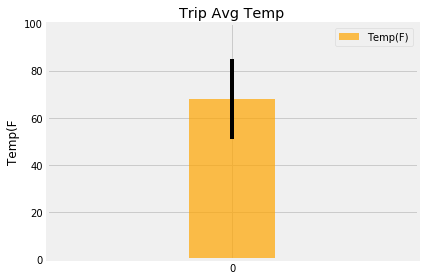

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df = pd.DataFrame({ 'Temp(F)':[result[1]]})
df.plot.bar( y='Temp(F)', rot=0,color='orange', width=0.15 , alpha=0.7, yerr=result[2]-result[0])
plt.ylim(0,100 )
plt.title(label = 'Trip Avg Temp')
plt.ylabel("Temp(F")
plt.tight_layout()
plt.show()



#fig, ax = plt.subplots()
#ax.errorbar(standard_errors, y=result[2]-result[1],fmt="o")

In [31]:
df = pd.DataFrame(precipitation[:], columns=[ 'date', 'prcp'])
df.set_index('date', inplace=True, )

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station,func.count(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation]
prcp = session.query(*sel).group_by(Measurement.station).\
    filter(Measurement.date >= '2017-01-01').filter(Measurement.date <= '2017-01-10').\
    filter(Measurement.station==Station.station).\
    order_by(func.count(Measurement.prcp)).all()
#prcp



In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
#normals=[]

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

month=1
day=11
r=np.arange(1,day)
dates=[]
for x in r:
    if x<10:
        c=f'01-0{x}'
    else:
        c=f'01-{x}'
    dates.append(c)
#start='01-01'
#end='01-10'
#dates=["01-01",'01-02','01-03','01-04','01-05','01-06','01-07','01-08','01-09','01-10']
normals=[]
for date in dates:    
    tob = daily_normals(date)[0]
    normals.append(tob)
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0)]

In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df = pd.DataFrame(normals, columns=[ 'TMIN', 'TAVG','TMAX'])
#index=pd.date_range(start='2018/01/01', end='2018/01/10', freq='D')
t_dates=[]
for date in dates:
    t_date=f'2018-{date}'
    t_dates.append(t_date)
df['trip_dates']=t_dates
df.set_index('trip_dates', inplace=True, )
df

TMIN       TAVG  TMAX
trip_dates                       
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0
2018-01-06  61.0  68.964912  76.0
2018-01-07  57.0  68.543860  76.0
2018-01-08  57.0  67.160714  75.0
2018-01-09  58.0  67.929825  78.0
2018-01-10  62.0  69.741379  77.0

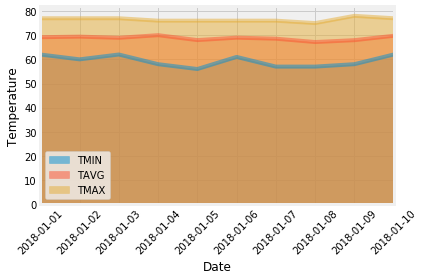

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
xticks=np.arange(0,10)
ax = df.plot.area(stacked=False)
plt.xticks(xticks, df.index, rotation=45)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()


#ax.set_xticklabels(df.index, rotation=90)
